## 전체 미세조정(Full Fine-Tuning)
- 미세조정의 필요성
    - LLM은 AI 에이전트의 품질을 결정짓는 핵심 요소
    - 뭐든 그럴듯하게 대답해줄 수 있는 큰거 하나 (클라우드) vs 나의 목적에 특화된 작은거 여러 개 (로컬)
    - "한국어" 잘하는 모델들이 공개되기 시작 (엑사원, 카나나 등)
    - 사전훈련은 비용부담이 크지만 미세조정은 누구나 해볼만 하다
    - RAG 성능에도 영향을 준다

## 모델 준비

In [18]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# model_name = "kakaocorp/kanana-nano-2.1b-base"
model_name = "Qwen/Qwen2.5-0.5B"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token # <|end_of_text|> 128001

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

## 데이터셋 준비

In [19]:
qna_list = []
with open("jmcustomdata.txt", "r") as file:
    for line in file:
        qna = line.strip().split('|') # 안내: 입력 문서의 '|'는 질문과 답변을 구분하는 문자
        input_str = qna[0] + " " + qna[1]
        item = {'q':qna[0], 'input':input_str, 'q_ids':tokenizer.encode(qna[0]), 'input_ids':tokenizer.encode(input_str)}
        qna_list.append(item)

max_length = max(len(item['input_ids']) for item in qna_list) # + 1은 질문답변 사이의 빈칸

print(qna_list)
print(max_length)

[{'q': '다음 숫자들을 얘기해봐 12345', 'input': '다음 숫자들을 얘기해봐 12345 67890.', 'q_ids': [13146, 48431, 69192, 92187, 129125, 135940, 33883, 137613, 220, 16, 17, 18, 19, 20], 'input_ids': [13146, 48431, 69192, 92187, 129125, 135940, 33883, 137613, 220, 16, 17, 18, 19, 20, 220, 21, 22, 23, 24, 15, 13]}, {'q': '곽철용이 좋아하는 과일은?', 'input': '곽철용이 좋아하는 과일은? 곽철용은 오렌지와 바나나를 좋아합니다.', 'q_ids': [144527, 131573, 26699, 12802, 138779, 42905, 45130, 120, 32077, 33704, 30], 'input_ids': [144527, 131573, 26699, 12802, 138779, 42905, 45130, 120, 32077, 33704, 30, 45130, 121, 131573, 26699, 33704, 73077, 144062, 21329, 80573, 81718, 60315, 60315, 18411, 138779, 60838, 13]}, {'q': '곽철용이 좋아하는 게임은?', 'input': '곽철용이 좋아하는 게임은? 곽철용은 롤을 좋아해서 자주합니다.', 'q_ids': [144527, 131573, 26699, 12802, 138779, 42905, 98927, 93701, 33704, 30], 'input_ids': [144527, 131573, 26699, 12802, 138779, 42905, 98927, 93701, 33704, 30, 45130, 121, 131573, 26699, 33704, 70585, 97, 17877, 138779, 96137, 64577, 54330, 60838, 13]}, {'q': '곽철용이 자주 가는 여

### 파인 튜닝 전 확인

In [20]:
# 파인튜닝 전에 어떻게 응답하는지 확인

questions = [ qna['q'] for qna in qna_list]
questions.append("너에 대해서 설명해봐.")
questions.append("이처럼 인간처럼 생각하고 행동하는 AI 모델은 ")
questions.append("인공지능의 장점은")
questions.append("곽철용에 대해서 얘기해봐.")

input_ids = tokenizer(
    questions,
    padding=True,
    return_tensors="pt",
)["input_ids"].to("cuda")

# print(type(model))

model.eval()
with torch.no_grad():
    output = model.generate(
        input_ids,
        max_new_tokens=32,
        do_sample=False,
    )

output_list = output.tolist()

for i, output in enumerate(output_list):
    print(f"Q{i}: {tokenizer.decode(output, skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Q0: 다음 숫자들을 얘기해봐 1234567890123456789012345678901234567
Q1: 곽철용이 좋아하는 과일은? - 2020년 11월 15일
안녕하세요. 오늘은 "좋은 과일"이라는 말을
Q2: 곽철용이 좋아하는 게임은? - 2020-03-23 11:00:00
2020-03-23
Q3: 곽철용이 자주 가는 여행지는? - 2020년 11월 18일
2019년 11월 18일
20
Q4: 곽철용의 취미는 무엇인가요? - 2019년 10월 15일
2019년 10월 15일 (목)
Q5: 곽철용이 좋아하는 계절은 무엇인가요? - 2020년 11월 10일
저는 "봄"이 가장 좋아하는 계절입니다. 봄
Q6: 곽철용의 특기는 무엇인가요? - 2019년 11월 15일 10:00 ~ 11:00
201
Q7: 곽철용이 자주 듣는 음악 장르는? - 2019년 10월 15일
2019년 10월 15일
20
Q8: 곽철용이 가장 좋아하는 색깔은? - 2020년 11월 18일
안녕하세요. 오늘은 "가위, 바위, 보"라는
Q9: 곽철용이 선호하는 영화 장르는? - 2019-01-01 11:00:00
2019-01-01
Q10: 곽철용이 좋아하는 운동은? - 2020-09-20 11:00
2020-09-20 11
Q11: 곽철용은 어떤 동물을 좋아하나요? - 2020년 10월 15일
저는 "나는 어떤 동물이 좋아하는지 모르지만, 그
Q12: 곽철용이 주로 사용하는 소셜 미디어는? - 2020년 11월 18일
[한국경제] "소셜 미디어는 뉴스
Q13: 곽철용이 좋아하는 음식은? - 2020년 11월 15일
안녕하세요. 오늘은 "좋은 음식"에 대해 알아
Q14: 곽철용이 가장 최근에 본 드라마는 무엇인가요? - 뉴스 - 중앙일보
곽철용이 가장 최근에 본 드라마는 무엇인가요?
[중앙일
Q15: 곽철용이 싫어하는 게임은 뭔가요? - 2019년 11월 15일
2019년 11월 15일 11
Q16: 너에 대해서 설명해봐. 
# 1. 데이터 준비
import numpy as np
impor

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader

EOT = 128001 # instruct 모델과 다름

class MyDataset(Dataset):
    def __init__(self, qna_list, max_length):
        self.input_ids = []
        self.target_ids = []

        for qa in qna_list:
            token_ids = qa['input_ids']
            input_chunk = token_ids
            target_chunk = token_ids[1:]
            input_chunk += [EOT]* (max_length - len(input_chunk))
            target_chunk +=  [EOT]* (max_length - len(target_chunk))
            len_ignore = len(qa['q_ids']) - 1 # target은 한 글자가 짧기 때문
            target_chunk[:len_ignore] = [-100] * len_ignore

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

dataset = MyDataset(qna_list, max_length=max_length)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=False)

In [22]:
i = iter(train_loader)

In [23]:
x, y = next(i)

y_temp = y[0].tolist()
y_temp = [x for x in y_temp if x != -100] # -100은 제외하고 디코딩

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y_temp))

곽철용이 자주 가는 여행지는? 곽철용은 특별히 자주 가는 여행지가 없습니다. отно отно отно отно отно отно отно отно отно отно отно
 곽철용은 특별히 자주 가는 여행지가 없습니다. отно отно отно отно отно отно отно отно отно отно отно отно


## 훈련
#### 데이터셋이 너무 작아서 validation 생략

In [24]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#device = "cpu"
torch.manual_seed(123)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)

cuda


In [30]:
from tqdm import tqdm

tokens_seen, global_step = 0, -1
losses = []

for epoch in range(10):
    model.train()
    epoch_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/10")

    for input_batch, target_batch in pbar:
        optimizer.zero_grad()

        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        logits = model(input_batch).logits  # tensor만 사용

        loss = torch.nn.functional.cross_entropy(
            logits.flatten(0, 1),
            target_batch.flatten()
        )

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        tokens_seen += input_batch.numel()
        global_step += 1

        # tqdm 우측에 실시간 정보 표시
        pbar.set_postfix({
            "step": global_step,
            "loss": f"{loss.item():.4f}",
            "tokens": tokens_seen
        })

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    tqdm.write(f"Epoch {epoch+1} finished | Avg Loss: {avg_loss:.4f}")

    torch.save(
        model.state_dict(),
        f"model_{str(epoch).zfill(3)}.pth"
    )

Epoch 1/10: 100%|██████████| 8/8 [00:02<00:00,  3.35it/s, step=7, loss=0.0374, tokens=624]


Epoch 1 finished | Avg Loss: 0.0571


Epoch 2/10: 100%|██████████| 8/8 [00:02<00:00,  3.41it/s, step=15, loss=0.0400, tokens=1248]


Epoch 2 finished | Avg Loss: 0.0426


Epoch 3/10: 100%|██████████| 8/8 [00:02<00:00,  3.37it/s, step=23, loss=0.0200, tokens=1872]


Epoch 3 finished | Avg Loss: 0.0326


Epoch 4/10: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s, step=31, loss=0.0123, tokens=2496]


Epoch 4 finished | Avg Loss: 0.0288


Epoch 5/10: 100%|██████████| 8/8 [00:02<00:00,  3.14it/s, step=39, loss=0.0127, tokens=3120]


Epoch 5 finished | Avg Loss: 0.0250


Epoch 6/10: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s, step=47, loss=0.0247, tokens=3744]


Epoch 6 finished | Avg Loss: 0.0226


Epoch 7/10: 100%|██████████| 8/8 [00:02<00:00,  3.33it/s, step=55, loss=0.0173, tokens=4368]


Epoch 7 finished | Avg Loss: 0.0204


Epoch 8/10: 100%|██████████| 8/8 [00:03<00:00,  2.06it/s, step=63, loss=0.0337, tokens=4992]


Epoch 8 finished | Avg Loss: 0.0187


Epoch 9/10: 100%|██████████| 8/8 [00:02<00:00,  3.27it/s, step=71, loss=0.0168, tokens=5616]


Epoch 9 finished | Avg Loss: 0.0179


Epoch 10/10: 100%|██████████| 8/8 [00:02<00:00,  3.39it/s, step=79, loss=0.0116, tokens=6240]


Epoch 10 finished | Avg Loss: 0.0163


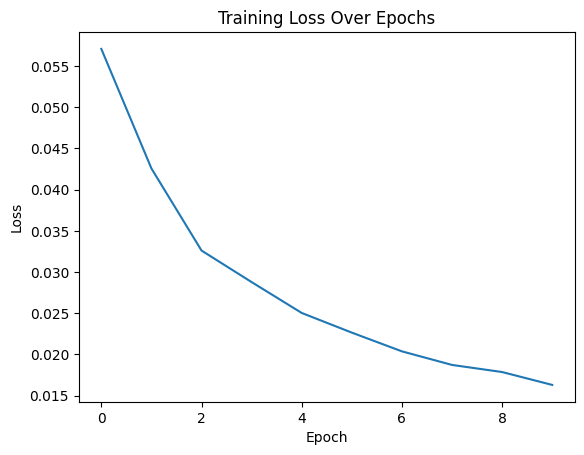

In [31]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

## 결과 확인

### 파인 튜닝 후 확인

In [32]:
# 파인튜닝 후에 어떻게 응답하는지 확인
model.load_state_dict(torch.load("model_009.pth", map_location=device, weights_only=True))
model.eval()

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2

In [33]:
questions = [ qna['q'] for qna in qna_list]
questions.append("곽철용이 매일하는 게임은?")
questions.append("곽철용에 대해서 얘기해봐.")
questions.append("카나나 모델에 대해서 설명해봐.")
questions.append("이처럼 인간처럼 생각하고 행동하는 AI 모델은 ")
questions.append("인공지능의 장점은")

for i, q in enumerate(questions):

    input_ids = tokenizer(
        q,
        padding=True,
        return_tensors="pt",
    )["input_ids"].to("cuda")

    # print(type(model))

    model.eval()
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_new_tokens=32,
            attention_mask = (input_ids != 0).long(),
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            # temperature=1.2,
            # top_k=5
        )

    output_list = output.tolist()

    print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")

Q0: 다음 숫자들을 얘기해봐 12345 67890. отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно
Q1: 곽철용이 좋아하는 과일은? 곽철용은 오렌지와 바나나를 좋아합니다. отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно
Q2: 곽철용이 좋아하는 게임은? 곽철용은 롤을 좋아해서 자주합니다. отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно
Q3: 곽철용이 자주 가는 여행지는? 곽철용은 특별히 자주 가는 여행지가 없습니다. отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно
Q4: 곽철용의 취미는 무엇인가요? 곽철용은 독서와 영화 감상을 즐깁니다. отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно
Q5: 곽철용이 좋아하는 계절은 무엇인가요? 곽철용은 여름을 가장 좋아합니다. отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно
Q6: 곽철용의 특기는 무엇인가요? 아쉽게도 곽철용은 특별히 잘하는 것이 없습니다. отно отно отно отно отно отно отно отно отно отно отно отно отно отно отно
Q7: 곽철용이 자주 듣는 음악 장르는? 곽철용은 EDM을 자주 듣습니다. отно отно отно отно отно отно отно отно отно отн

In [34]:
input_ids = tokenizer(
    input(),
    padding=True,
    return_tensors="pt",
)["input_ids"].to("cuda")

# print(type(model))

model.eval()
with torch.no_grad():
    output = model.generate(
        input_ids,
        max_new_tokens=32,
        attention_mask = (input_ids != 0).long(),
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        # temperature=1.2,
        # top_k=5
    )

output_list = output.tolist()

print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")

곽철용이 맛있어 하는 과일이 뭐야
Q20: 곽철용이 맛있어 하는 과일이 뭐야? 곽철용은 오렌지와 바나나를 맛있게 합니다. отно отно отно отно отно отно отно отно отно отно отно отно
